# Wisconsin Breast Cancer dataset

### preprocessing

The dataset contains 11 attributes of which 1 is the patient ID which will be omited as it is superfluous, and 1 attribute which is the classification, which we will try to learn. The data does contain some missing values. To determine if we should try to guestimate these missing values or if we can safely omit these entries I'll evaluate them first.



In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

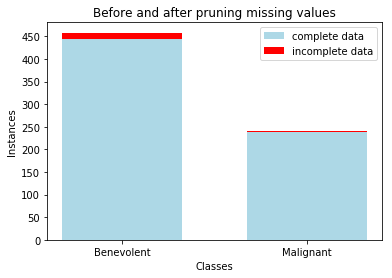

In [4]:
costFP = 100
costFN = 5

import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import sklearn.preprocessing as skpr
from sys import exit
import numpy as np
import matplotlib.pyplot as plt

# open data-file
file1 = open("./datasets/wisconsindata.txt","r")
data = []
for line in file1:
    data.append(line.rstrip().split(","))

# preprocess data

data = np.asarray(data, dtype=None)
#remove patient id, let classification in.
data = data[:,1:11]

# there should be 16 instances of missing data out of 699 instances, 2.2% remove them (check for bias)
# retrieve the Class 2/4 if there is missing data. Otherwise 0
def fnd(x): 
    if "?" in x:
        return int(x[-1])
    else:       
        return int()
# column of classes where data is missing: plus the index of said entry
x = list(map( fnd , data))
index = np.nonzero(x)[0]


index = list(index)
index.reverse()
data = list(data)
#remove missing data
for i in index:
    del data[i]
data = np.array(data)


C1Invalid = len([ i for i in x if i == 2  ])
C2Invalid = len([ i for i in x if i == 4  ])
C1Valid = len([ i for i in data[:,-1] if i == '2'  ])
C2Valid = len([ i for i in data[:,-1] if i == '4'  ])

# plot data
ind = np.arange(2)    # the x locations for the groups
width = .65           # the width of the bars
p1 = plt.bar(ind, [C1Valid,C2Valid], width, color='lightblue')
p2 = plt.bar(ind, [C1Invalid,C2Invalid], width,bottom=[C1Valid,C2Valid],color = 'red')
plt.ylabel('Instances')
plt.xlabel('Classes')
plt.title('Before and after pruning missing values')
plt.xticks(ind ,('Benevolent', 'Malignant'))
plt.yticks(np.arange(0, C1Valid+C1Invalid, 50))
plt.legend( ('complete data', 'incomplete data'))
plt.show()

# separate data from classes
Y = data[:,-1].astype(np.float)
X = data[:,0:-1].astype(np.float)


Since there are fairly few datapoints with missing data, and since it doesn't exhorbitantly influence the proportion of the two classes I decide to simply omit these missing data points.

### Principal Component Analysis

To see if we can shrink the 9 Dimensional attribute space to a lower dimension I'll apply PCA. Later I will compare a data set that has PCA applied to it and a dataset that hasn't to see if this was the right thing to do.

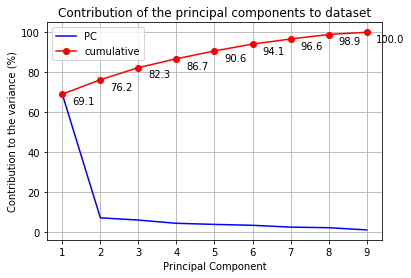

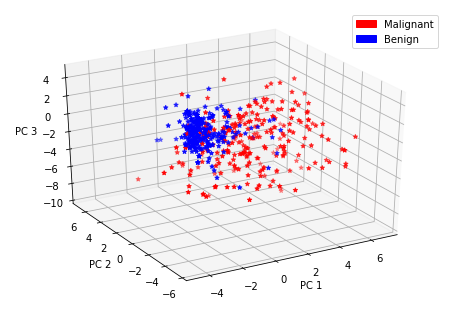

In [6]:
#%% PCA

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

#
######  applying PCA ######
#normalize all columns: doesn't need to be normalized because they are all on a scale of 1-10


mu = X.mean(0)                   # determine mean per column
mu = np.tile(mu,(len(X[:,0]),1)) # repeat vector into matrix
#mean center the data
Y1 = X - mu 
#
U, s, V = np.linalg.svd(Y1, full_matrices=True) #s is the vector which contains the values of a diagonal-matrix
# to matrix for matrix multiplication
V = np.matrix(V)
Y1 = np.matrix(Y1)

#projection of data onto all 9 PC's
Z = np.zeros([len(data),9])
for i in range(9):
    Z[:,i] = (Y1*V[:,i]).ravel()


rho = s**2/sum(s**2)

plt.plot(rho*100,'b',label = 'PC')
plt.plot(np.cumsum(rho)*100,'r-o',label = 'cumulative')


plt.xlabel('Principal Component')
plt.ylabel('Contribution to the variance (%)')
plt.title('Contribution of the principal components to dataset')
for i in range(9):
    plt.text(range(9)[i]+0.25,np.cumsum(rho)[i]*100-5 , str(round(np.cumsum(rho)[i]*100,1)), color='black')
plt.grid(True)
plt.xticks(range(0,9),range(1,10))
plt.legend()
plt.show()




import matplotlib.patches as mpatches

Clist = [] # list of colors depending on the classification
for i in range(len(Y)):
    if Y[i]==4:
        Clist.append('red')
    else:
        Clist.append('blue')


fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(Z[:,0],Z[:,1],Z[:,2], color = Clist, marker='*')
angle = 240
ax.view_init(30, angle)
red_patch = mpatches.Patch(color='red', label='Malignant')
blue_patch = mpatches.Patch(color='blue', label='Benign')
plt.legend(handles=[red_patch,blue_patch])
xLabel = ax.set_xlabel('PC 1', linespacing=3.2)
yLabel = ax.set_ylabel('PC 2', linespacing=3.1)
zLabel = ax.set_zlabel('PC 3', linespacing=3.4)

plt.show()



### Decision Tree
When a decision Tree is fitted to the date we get the following decision tree of depth 5.

In [7]:
import sys
sys.path.append('./modules/')
import treeprint as tp

attributeNames = ['Clump Thickness', 'Uniformity of Cell Size','Uniformity of Cell Shape',
'Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin',
'Normal Nucleoli','Mitoses'] 


#print(np.where(Y==2))


classNames = []
for i in range(len(Y)):
    
    if Y[i]==2:
        classNames.append('B')
    elif Y[i]==4:
        classNames.append('M')


from sklearn import tree
import sklearn
import graphviz 

dtc = tree.DecisionTreeClassifier(min_samples_split=100)# create tree         #DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
dtc = dtc.fit(X, classNames)                                     # fit on data

tp.tree_print(dtc, attributeNames, classNames);# print the decision tree


               |->5  B
               |
            |->4 then if Bare Nuclei =< 4.5: go to 5, else go to 6
            |  |
            |  |->6  B
            |
         |->3 then if Normal Nucleoli =< 9.0: go to 4, else go to 7
         |  |
         |  |->7  B
         |
      |->2 then if Clump Thickness =< 6.5: go to 3, else go to 8
      |  |
      |  |->8  B
      |
   |->1 then if Bare Nuclei =< 5.5: go to 2, else go to 9
   |  |
   |  |->9  B
   |
if Uniformity of Cell Size =< 2.5: go to 1, else go to 10
   |
   |  |->11  B
   |  |
   |->10 else if Uniformity of Cell Shape =< 2.5: go to 11, else go to 12
      |
      |  |->13  B
      |  |
      |->12 else if Uniformity of Cell Size =< 4.5: go to 13, else go to 14
         |
         |  |->15  B
         |  |
         |->14 else if Marginal Adhesion =< 1.5: go to 15, else go to 16
            |
            |  |->17  B
            |  |
            |->16 else if Normal Nucleoli =< 2.5: go to 17, else go to 18
               |
  

### Decision Tree varied over depth

When we vary the depth of the decision tree and look at both the accuracy, and in terms of total cost, then a depth of 5 does seem to be optimal. The total cost is determined by the weights of the False Positive 100 and the False Negative of 10. These weights are admittedly random, although a FP should be punished more severely than a FN when the objective is to classify cancern.

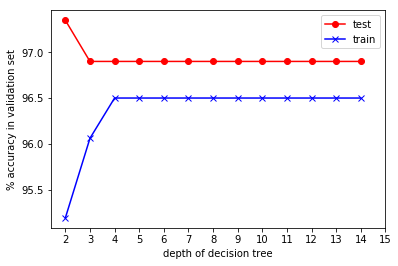

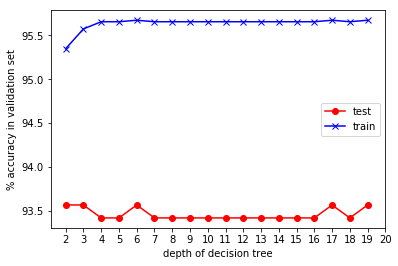

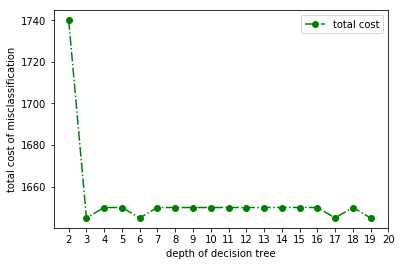

In [8]:
from scipy.io import loadmat
from sklearn import model_selection, tree
from sklearn.model_selection import train_test_split

# Load Matlab data file and extract variables of interest

#X = ...
#y = ...

#attributeNames = ...
#classNames = ...

# Simple holdout-set crossvalidation
#X_train, X_test, y_train, y_test = ...

#write your code here

N = 15
## initialize
N_iterations = len(range(2,N))
accuracy_train = np.zeros(N_iterations)
accuracy_test = np.zeros(N_iterations)







# Simple holdout-set crossvalidation
X_train, X_test, y_train, y_test = train_test_split(X, classNames, test_size=0.33)

from sklearn import tree
import treeprint as tp
import sklearn
import matplotlib.pyplot as plt



####



j=0
for i in range(2,N):
    depth = i
    dtc = tree.DecisionTreeClassifier(max_depth=depth ,min_samples_split=100)# create tree         #DecisionTreeClassifier(criterion=’gini’, splitter=’best’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, presort=False)
    dtc = dtc.fit(X_train, y_train)                                     # fit on data


    #validation:
    y_predicted = dtc.predict(X_test)
    y_predicted_train = dtc.predict(X_train)
    
    Ncorrect = np.sum(y_test == y_predicted)
    Ncorrect_train = np.sum(y_train == y_predicted_train)
    
    accuracy_test[j] = round(float(Ncorrect)/len(y_test)*100,2)
    accuracy_train[j] = round(float(Ncorrect_train)/len(y_train)*100,2)
    j+=1
    
plt.plot(range(2,N_iterations+2),accuracy_test,'r-o', label = "test")
plt.plot(range(2,N_iterations+2),accuracy_train,'b-x',label = "train")
plt.ylabel("% accuracy in validation set")
plt.xlabel("depth of decision tree")
plt.xticks(range(2,N+1))
plt.legend()
plt.show()


#%%

    





#%%
K=10
N = 20
from sklearn.model_selection import KFold
#for t in range(5):
kf = KFold(n_splits=K)
N_iterations = len(range(2,N))
accuracy_train = np.zeros([N_iterations,K])
accuracy_test = np.zeros([N_iterations,K])

TP = np.zeros([N_iterations,K])
TN = np.zeros([N_iterations,K])
FP = np.zeros([N_iterations,K])
FN = np.zeros([N_iterations,K])

kf.get_n_splits(X)


m=0
for train_index, test_index in kf.split(X):   #performs the split K times
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

  

    j=0
    for i in range(2,N):
        depth = i
        dtc = tree.DecisionTreeClassifier(max_depth=depth ,min_samples_split=100)#create tree
        dtc = dtc.fit(X_train, y_train)                                          #fit on data

        #validation:
        y_predicted_test = dtc.predict(X_test)
        y_predicted_train = dtc.predict(X_train)

        Ncorrect_test = np.sum(y_test == y_predicted_test)
        Ncorrect_train = np.sum(y_train == y_predicted_train)

        accuracy_test[j,m] = round(float(Ncorrect_test)/len(y_test)*100,2)
        accuracy_train[j,m] = round(float(Ncorrect_train)/len(y_train)*100,2)
        
        
       
        
        TP[j,m] = len(list(set(np.where(y_test==2)[0]).intersection(set(np.where(y_predicted_test ==2)[0]))))#*100/len(y_test)
        TN[j,m] = len(list(set(np.where(y_test==4)[0]).intersection(set(np.where(y_predicted_test ==4)[0]))))#*100/len(y_test)
        FP[j,m] = len(list(set(np.where(y_test==4)[0]).intersection(set(np.where(y_predicted_test ==2)[0]))))#*100/len(y_test)
        FN[j,m] = len(list(set(np.where(y_test==2)[0]).intersection(set(np.where(y_predicted_test ==4)[0]))))#*100/len(y_test)
        
        
        
        j+=1#sum over depth
    m+=1#sum over training sets

    A = np.average(accuracy_test,1)
B = np.average(accuracy_train,1)

plt.plot(range(2,N_iterations+2),A,'r-o', label = "test")
plt.plot(range(2,N_iterations+2),B,'b-x',label = "train")

plt.ylabel("% accuracy in validation set")
plt.xlabel("depth of decision tree")
plt.xticks(range(2,N+1))
plt.legend()
plt.show()

TP = np.matrix.sum(np.matrix(TP),1)
TN = np.matrix.sum(np.matrix(TN),1)
FP = np.matrix.sum(np.matrix(FP),1)
FN = np.matrix.sum(np.matrix(FN),1)


plt.plot(range(2,N_iterations+2),FP*costFP+FN*costFN,'g-.o', label = "total cost")

plt.ylabel("total cost of misclassification")
plt.xlabel("depth of decision tree")
plt.xticks(range(2,N+1))
plt.legend()
plt.show()

tree_acc = A[3]
tree_cost = (FP*costFP+FN*costFN)[3]


### Comparing multiple SVMs

KFold(n_splits=10, random_state=None, shuffle=False)
KFold(n_splits=10, random_state=None, shuffle=False)
KFold(n_splits=10, random_state=None, shuffle=False)
KFold(n_splits=10, random_state=None, shuffle=False)
KFold(n_splits=10, random_state=None, shuffle=False)
KFold(n_splits=10, random_state=None, shuffle=False)


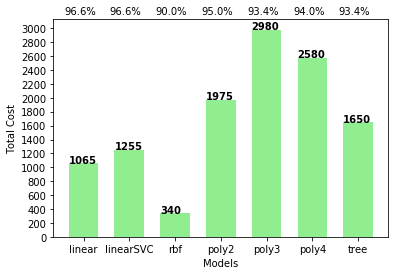

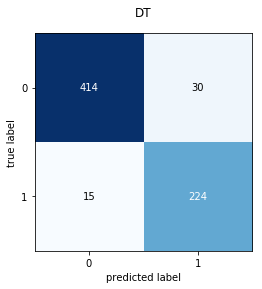

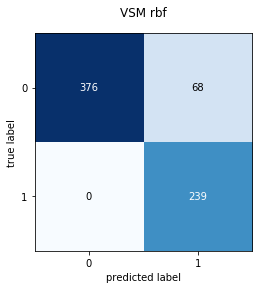

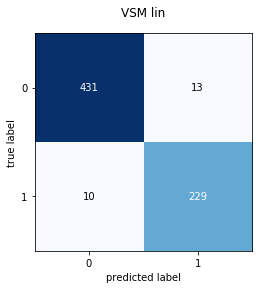

In [9]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Sat Jan 27 12:48:14 2018

@author: anton
"""

#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 18 19:12:09 2018

@author: anton
"""


from sklearn import svm

C=1.0

from scipy.io import loadmat
from sklearn import model_selection, tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold

linestyle = ['r-', 'g--', 'b:', 'y-.','c-','m.']
                           
std = []
ac = []
cost = []
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=2, C=C),
          svm.SVC(kernel='poly', degree=3, C=C),
          svm.SVC(kernel='poly', degree=4, C=C))
modelname = ["linear","linearSVC","rbf","poly2","poly3","poly4",'tree']
for L in range(6):
    
    C = 1.0
    clf = models[L]
    clf.fit(X, Y)  
    
    
    
    TP2 = np.zeros(10)
    TN2 = np.zeros(10)
    FP2 = np.zeros(10)
    FN2 = np.zeros(10)
    
    
    
    
    kf = KFold(n_splits=10)
    kf.get_n_splits(X)
    
    print(kf)  
    KFold(n_splits=10, random_state=None, shuffle=False)
    
    i = 0
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = Y[train_index], Y[test_index]
        
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        #print("len = {}".format(len(y_test)))
        TP2[i] = len(list(set(np.where(y_test==2)[0]).intersection(set(np.where(y_predict ==2)[0]))))#*100/len(y_test)
        TN2[i] = len(list(set(np.where(y_test==4)[0]).intersection(set(np.where(y_predict ==4)[0]))))#*100/len(y_test)
        FP2[i] = len(list(set(np.where(y_test==4)[0]).intersection(set(np.where(y_predict ==2)[0]))))#*100/len(y_test)
        FN2[i] = len(list(set(np.where(y_test==2)[0]).intersection(set(np.where(y_predict ==4)[0]))))#*100/len(y_test)
        
        i=i+1
        
        
    
    scores = cross_val_score(clf, X[:,:], Y, cv=10)
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    #ac.append(scores.mean()*100)
    #std.append(scores.std())
    
    TP2 = sum(TP2)
    TN2 = sum(TN2)
    FP2 = sum(FP2)
    FN2 = sum(FN2)
    
    ac.append((TP2+TN2)/(TP2+TN2+FN2+FP2)*100)
    
    #plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    
    
    cost.append(FP2*costFP+FN2*costFN)
    
    if L==2:
        rbf_matrix = np.array([[TP2,FN2],[FP2,TN2]])
    if L==0:
        lin_matrix = np.array([[TP2,FN2],[FP2,TN2]])
    
    
#%%    
# add the cost of the Decision Tree model
cost.append(tree_cost)
ac.append(tree_acc)
#%%

ind = np.arange(7)    # the x locations for the groups
width = .65       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, cost, width, color='lightgreen')


plt.ylabel('Total Cost')
plt.xlabel('Models')
#plt.title('The cost per model and accuracy')
plt.xticks(ind ,modelname)
plt.yticks(np.arange(0, 3100, 200))

for i in ind:
    plt.text(ind[i]-width/2, cost[i] + .25, str(int(cost[i])), color='black', fontweight='bold')
    plt.text(ind[i]-width/2-0.1, 3200, str(round(ac[i],1))+"%", color='black')

plt.show()

cost_rbf = cost[2]
ac_rbf = ac[2]

#%%



binary = np.array([[np.array(TP[5])[0][0], np.array(FN[5])[0][0]],
                   [np.array(FP[5])[0][0], np.array(TN[5])[0][0]]])
fig, ax = plot_confusion_matrix(conf_mat=binary.astype(int))
plt.title("DT")
plt.show()

#%%

binary = rbf_matrix.astype(int)
fig, ax = plot_confusion_matrix(conf_mat=binary)
plt.title("VSM rbf")
plt.show()

#%%
binary = lin_matrix.astype(int)
fig, ax = plot_confusion_matrix(conf_mat=binary)
plt.title("VSM lin")
plt.show()



We can see that the Support Vector Machine with Radial Basis Functions has the best performance despite its lower accuracy, and that it achieves this by having 0 False Positives!